<a href="https://colab.research.google.com/github/ManuelProy/digital-invoice/blob/main/digital-invoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice OCR notebook series: Problem definition

> Given a arbitrary photo containing a receipt, extract grand total number

![](https://storage.googleapis.com/www.forwardit.lv/kaggle/receipt_home_kaggle.png)

The solution is divided into smaller tasks:

1. Get a scanned version of receipt by restoring perspective (done in the [previous notebook](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv))
2. **Apply OCR to find all texts within image**
3. **Find grand total as the largest number among recognized texts**

> One should remember that some tasks could be solved with traditional computer vision algorithms

This work aims to address a common pitfall among machine learning practitioners: trying to solve simple problems with the complex tools.

# About this notebook

This is a **part two notebook** in the *Receipt OCR with OpenCV* series. [Previously](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv) we have extracted a scanned version of the receipt out of the image. This notebook deals with the second step of the process: reading text information from it.
* Locating text boxes on the image
* Extracting all the texts from the image
* Obtaining grand total as the largest floating point number among texts

Let's get started!

In [39]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! sudo apt-get install tesseract-ocr-spa

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-spa
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 951 kB of archives.
After this operation, 2,309 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-spa all 1:4.00~git30-7274cfa-1.1 [951 kB]
Fetched 951 kB in 0s (3,694 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dia

In [3]:
! pip install Pillow
! pip install pytesseract

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

Defining helper methods:

In [5]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [6]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

We will use a scanned version of the receipt, which is the output of the [previous notebook in the series](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv):

In [8]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


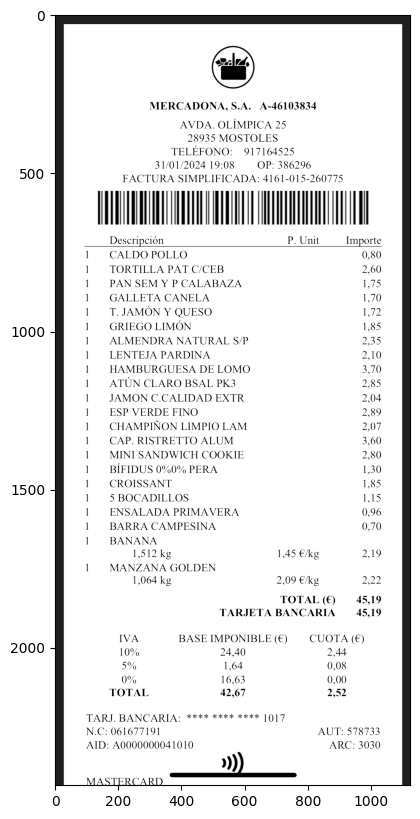

In [41]:
file_name = '/content/drive/MyDrive/dig-invoice/fact1.jpeg'
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)

# Step 1: Text box detection

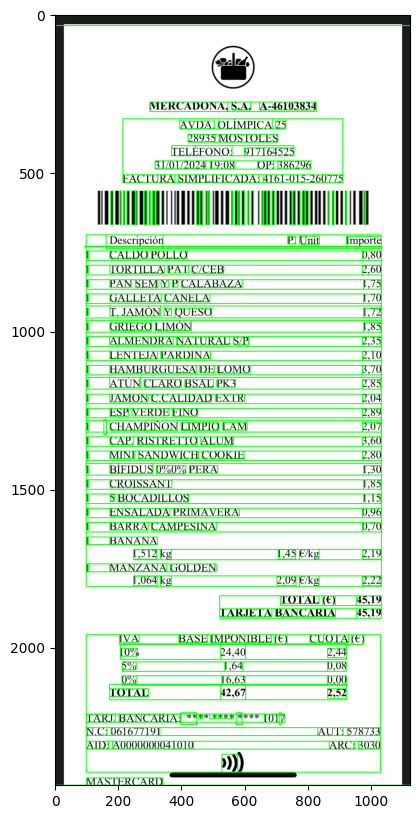

In [42]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)

# Step 2: Text recognition

In [43]:
extracted_text = pytesseract.image_to_string(image,lang="spa")
print(extracted_text)
type(extracted_text)


 

MERCADONA, S.A. A-46103834

AVDA. OLÍMPICA 25
28935 MOSTOLES
TELÉFONO: 917164525
31/01/2024 19:08 OP: 386296
FACTURA SIMPLIFICADA: 4161-015-260775

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

Descripción P. Unit Importe
1. CALDO POLLO 0,80
1 TORTILLA PAT C/CEB 2,60
1. PAN SEM Y P CALABAZA 1,75
1. GALLETA CANELA 1,70
1 T.JAMÓN Y QUESO 1,72
1. GRIEGO LIMÓN 1,85
1. ALMENDRA NATURAL S/P 2,35
1. LENTEJA PARDINA 2,10
1. HAMBURGUESA DE LOMO 3,70
1  ATÚNCLARO BSAL PK3 2,85
1 JAMONC.CALIDAD EXTR 2,04
1. ESP VERDE FINO 2,89
1. CHAMPIÑON LIMPIO LAM 2,07
1. CAP. RISTRETTO ALUM 3,60
1. MINI SANDWICH COOKIE 2,80
1 BÍFIDUS 0%0% PERA 1,30
1. CROISSANT 1,85
1. SBOCADILLOS 1,15
1. ENSALADA PRIMAVERA 0,96
1. BARRA CAMPESINA 0,70
1. BANANA
1,512 kg 1,45 €/kg 2,19
1. MANZANA GOLDEN
1,064 kg 2,09 €/kg 2,22

TOTAL (€) 45,19
TARJETA BANCARIA 45,19

IVA BASE IMPONIBLE (€) CUOTA (€)
10% 24,40 2,44
5% 1,64 0,08
0% 16,63 0,00
TOTAL 42,67 2,52
TARJ. BANC

str

# Step 3: Extracting invoice lines

We will use regular expression to extract all floating point numbers out of the all detected texts.

In [44]:
patron = r'\b\d+,\d+\b'
resultados = re.findall(patron, extracted_text)

print(resultados)

['0,80', '2,60', '1,75', '1,70', '1,72', '1,85', '2,35', '2,10', '3,70', '2,85', '2,04', '2,89', '2,07', '3,60', '2,80', '1,30', '1,85', '1,15', '0,96', '0,70', '1,512', '1,45', '2,19', '1,064', '2,09', '2,22', '45,19', '45,19', '24,40', '2,44', '1,64', '0,08', '16,63', '0,00', '42,67', '2,52']


Grand total is the largest one:

In [45]:
def lines(extracted_text):
    lineas_con_numeros = [linea for linea in extracted_text.splitlines() if re.search(r'^(?=.*[a-zA-Z])(?=.*\d.*,\d).*$', linea)]
    diccionario = {f"Línea {i + 1}": linea for i, linea in enumerate(lineas_con_numeros)}

    return(diccionario)

In [46]:
lines(extracted_text)



{'Línea 1': '1. CALDO POLLO 0,80',
 'Línea 2': '1 TORTILLA PAT C/CEB 2,60',
 'Línea 3': '1. PAN SEM Y P CALABAZA 1,75',
 'Línea 4': '1. GALLETA CANELA 1,70',
 'Línea 5': '1 T.JAMÓN Y QUESO 1,72',
 'Línea 6': '1. GRIEGO LIMÓN 1,85',
 'Línea 7': '1. ALMENDRA NATURAL S/P 2,35',
 'Línea 8': '1. LENTEJA PARDINA 2,10',
 'Línea 9': '1. HAMBURGUESA DE LOMO 3,70',
 'Línea 10': '1  ATÚNCLARO BSAL PK3 2,85',
 'Línea 11': '1 JAMONC.CALIDAD EXTR 2,04',
 'Línea 12': '1. ESP VERDE FINO 2,89',
 'Línea 13': '1. CHAMPIÑON LIMPIO LAM 2,07',
 'Línea 14': '1. CAP. RISTRETTO ALUM 3,60',
 'Línea 15': '1. MINI SANDWICH COOKIE 2,80',
 'Línea 16': '1 BÍFIDUS 0%0% PERA 1,30',
 'Línea 17': '1. CROISSANT 1,85',
 'Línea 18': '1. SBOCADILLOS 1,15',
 'Línea 19': '1. ENSALADA PRIMAVERA 0,96',
 'Línea 20': '1. BARRA CAMPESINA 0,70',
 'Línea 21': '1,512 kg 1,45 €/kg 2,19',
 'Línea 22': '1,064 kg 2,09 €/kg 2,22',
 'Línea 23': 'TOTAL (€) 45,19',
 'Línea 24': 'TARJETA BANCARIA 45,19',
 'Línea 25': 'TOTAL 42,67 2,52'}

In [47]:
import re

texto = "Línea sin decimales ni letras\nLínea con el número 42\nOtra línea con texto\n123,45"

lineas_filtradas = [linea for linea in texto.splitlines() if re.match(r'^(?=.*[a-zA-Z])(?=.*\d)|(?=[^a-zA-Z\d])$', linea)]

print(lineas_filtradas)


['Línea con el número 42']


Feel free to experiment with other regular expressions to find VAT number, company name, date or even read receipt positions!

# Resources

1. [OCR a document, form, or invoice with Tesseract, OpenCV, and Python](https://www.pyimagesearch.com/2020/09/07/ocr-a-document-form-or-invoice-with-tesseract-opencv-and-python/) by Adrian Rosebrock
2. [Text Detection and Extraction using OpenCV and OCR](https://www.geeksforgeeks.org/text-detection-and-extraction-using-opencv-and-ocr/) by Anandh Jagadeesan
3. [A comprehensive guide to OCR with Tesseract, OpenCV and Python](https://nanonets.com/blog/ocr-with-tesseract/) by Filip Zelic & Anuj Sable